# Проект: Прогнозирование доходности ОФЗ с CatBoost и Transformer
## Введение
Прогнозирование динамики доходности государственных облигаций (ОФЗ) — критически важная задача для управления портфелем фиксированного дохода. В данном проекте мы разрабатываем модель для предсказания yield-to-maturity (YTM) конкретного выпуска ОФЗ, комбинируя:

                Фундаментальные показатели (ключевая ставка, инфляция)

                Технические характеристики облигации (дюрация, волатильность)

                Временные паттерны доходности

Особенность подхода — глубокая аналитика единичного инструмента вместо сравнения множества облигаций.

## Ход работы:

### Первичный анализ данных

        Сбор исторических данных по конкретному выпуску ОФЗ через Tinkoff Invest API

        Загрузка макроэкономических показателей (ключевая ставка ЦБ, инфляция, индексы MOEX)

        Оценка качества данных: поиск пропусков, аномалий, анализ распределений

### Feature Engineering

        Расчет финансовых показателей:

            Спред доходности относительно ключевой ставки

            Упрощенный расчет дюрации

            Скользящая волатильность доходности (30/60 дней)

            Отклонение от скользящих средних

        Добавление внешних факторов:

            Изменение ключевой ставки (абсолютное и %)

            Динамика индекса MOEX

            Инфляционные ожидания

### Baseline-модель: CatBoost

        Подготовка признаков и целевой переменной (прогноз цены на N дней)

        Разделение данных

        Интерпретация через SHAP-значения:

### Усложнение модели: Transformer

        Анализ, стоит ли усложнение вычислительных затрат

### Выводы и рекомендации

        Какие факторы сильнее всего влияют на доходность?

        Когда достаточно CatBoost, а когда нужен Transformer?

        Как интегрировать модель в инвестиционный процесс банка?

### 1. Импорты

In [59]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tinkoff.invest import Client, InstrumentStatus, CandleInterval
from tinkoff.invest.services import SandboxService
import warnings
import time
from tabulate import tabulate
import requests
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

### 2. Загрузка токена из .env

In [60]:
load_dotenv()
TOKEN = os.getenv("TOKEN")

### 3. Создание песочницы

In [61]:
def get_sandbox_account(token):
    with Client(token) as client:
        sandbox = client.sandbox
        
        accounts = sandbox.get_sandbox_accounts().accounts
        
        if accounts:
            print(f"Найден существующий счет: {accounts[0].id}")
            return accounts[0].id
        else:
            try:
                new_account = sandbox.open_sandbox_account()
                print(f"Создан новый счет: {new_account.account_id}")
                return new_account.account_id
            except Exception as e:
                print(f"Не удалось создать счет. Ошибка: {e}")
                return None
            
account_id = get_sandbox_account(TOKEN)            

Найден существующий счет: ef3f175f-f5c4-4311-92f2-83c03b9ceebf


### 4. Получение списка облигаций

In [62]:
def load_bonds(token):
    with Client(token) as client:
        response = client.instruments.bonds(
            instrument_status=InstrumentStatus.INSTRUMENT_STATUS_BASE
        )
        bonds = []
        for b in response.instruments:  
            if ('ОФЗ' in b.name) or (b.ticker.startswith('SU')) or ('государственн' in b.name.lower()):
                bonds.append({
                    'figi': b.figi,
                    'ticker': b.ticker,
                    'name': b.name,
                    'coupon': b.coupon_quantity_per_year,
                    'maturity_date': b.maturity_date
                })
        return pd.DataFrame(bonds)


bonds_df = load_bonds(TOKEN)
bonds_df.head()



,figi,ticker,name,coupon,maturity_date
0,BBG00XV43CN9,SU29017RMFS9,ОФЗ 29017,4,2032-08-25 00:00:00+00:00
1,BBG01BJBR2W0,SU26241RMFS8,ОФЗ 26241,2,2032-11-17 00:00:00+00:00
2,BBG0024TRF04,SU46023RMFS6,ОФЗ 46023,2,2026-07-23 00:00:00+00:00
3,BBG00PBZNWM4,SU26230RMFS1,ОФЗ 26230,2,2039-03-16 00:00:00+00:00
4,BBG007Z5F748,SU29009RMFS6,ОФЗ 29009,2,2032-05-05 00:00:00+00:00


всё отлично список получен

### 5. Загрузка данных

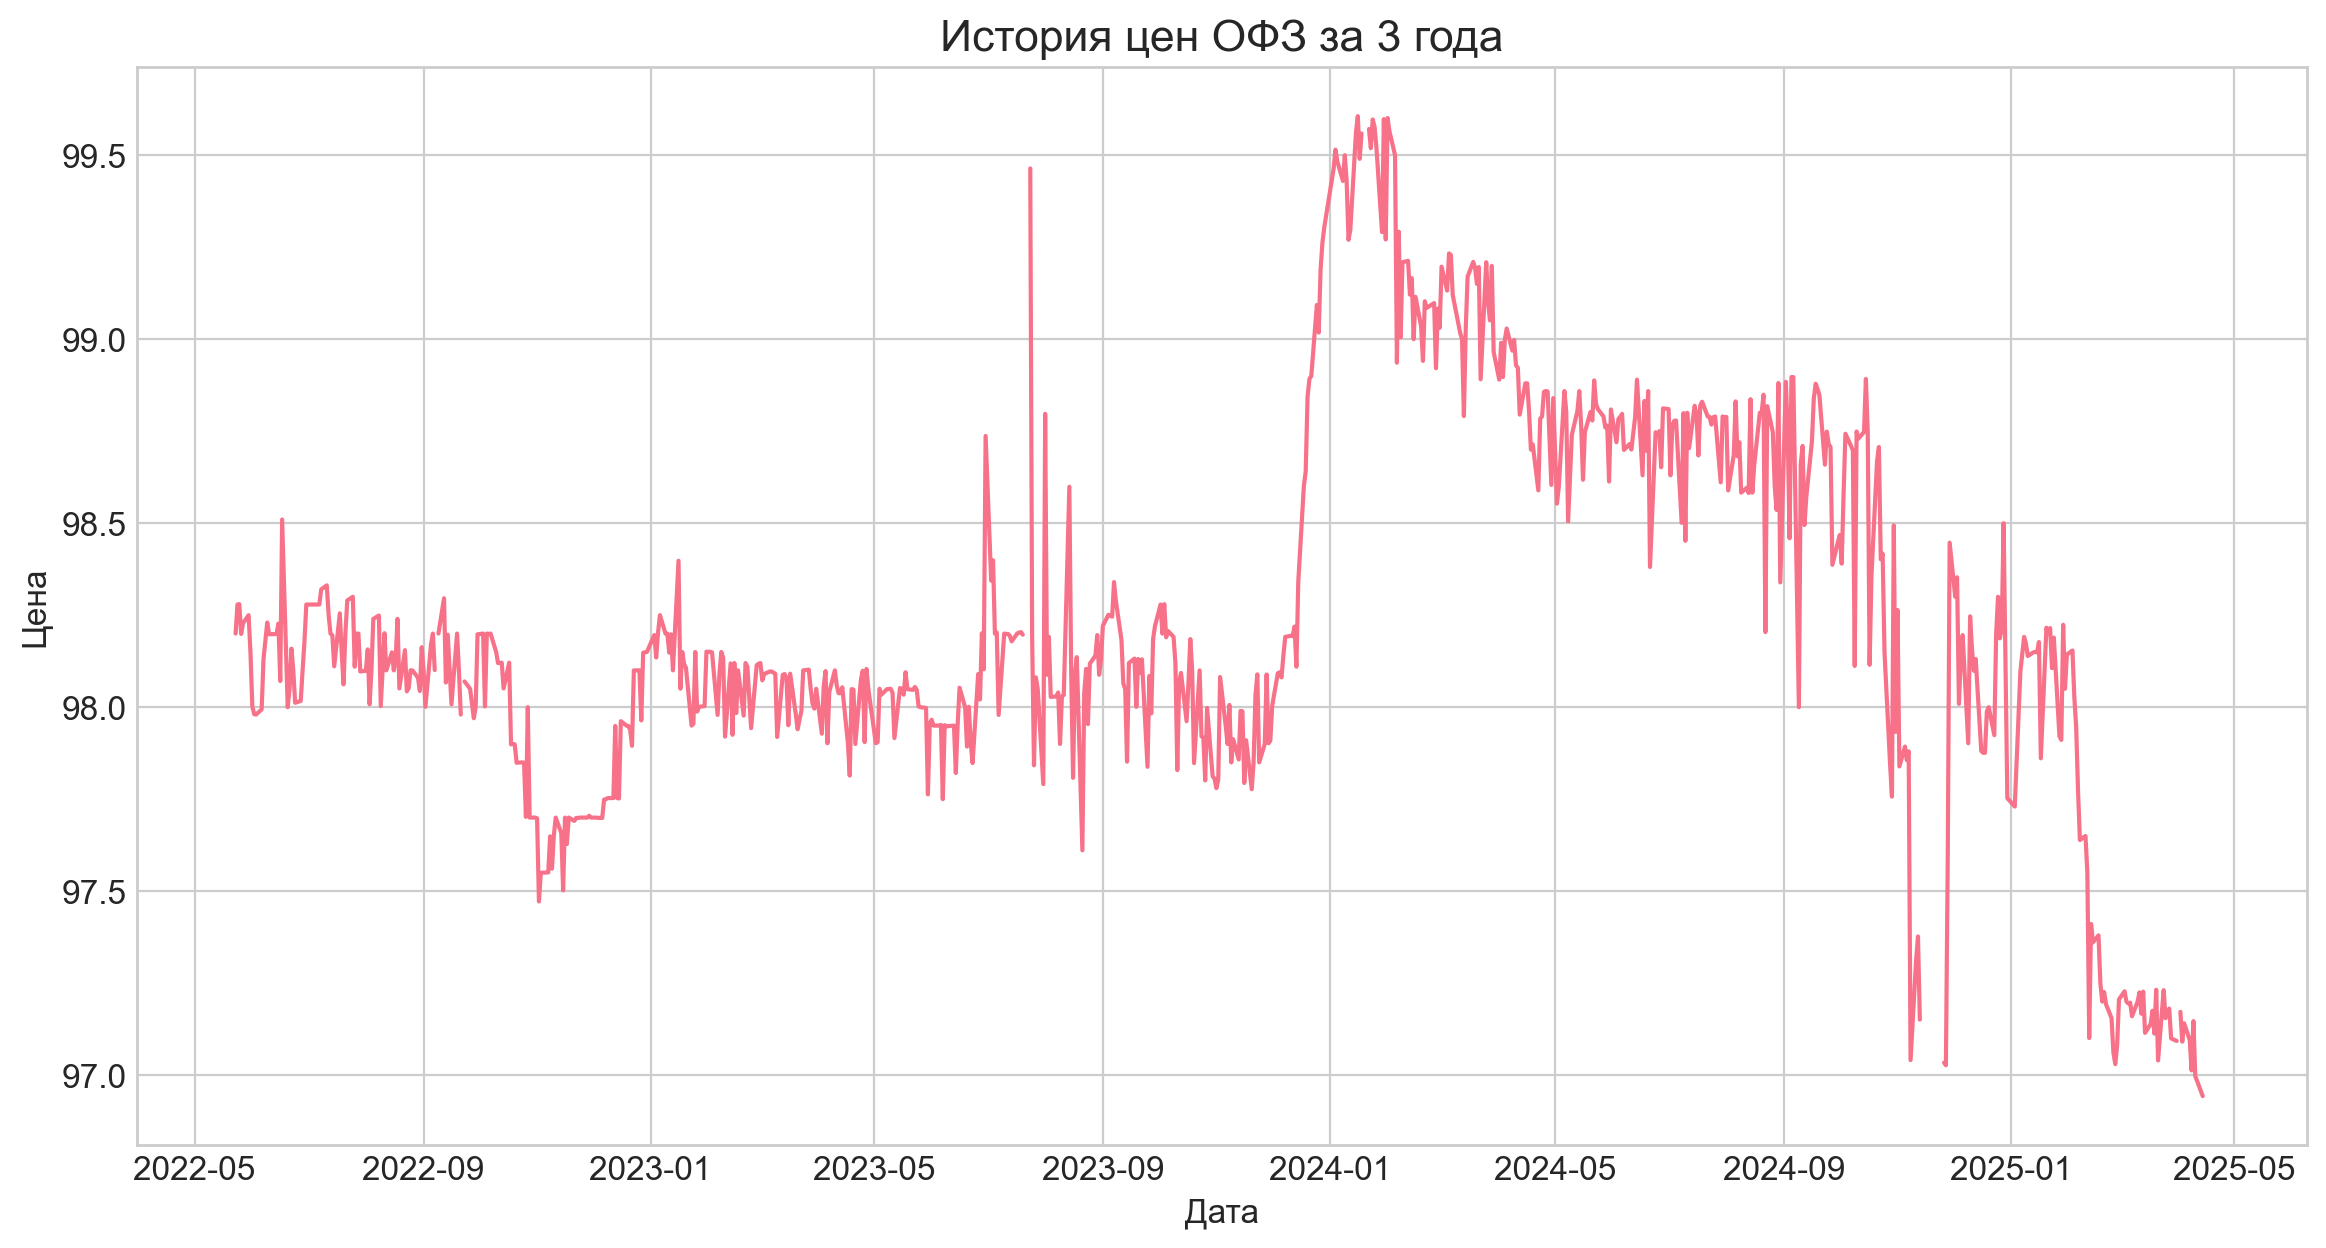

In [63]:
def get_history(token, figi, total_days=365*3):
    max_days_per_request = 300 
    history = []
    
    with Client(token) as client:
        remaining_days = total_days
        end_date = datetime.utcnow()
        
        while remaining_days > 0:
            chunk_days = min(remaining_days, max_days_per_request)
            start_date = end_date - timedelta(days=chunk_days)
            
            candles = client.market_data.get_candles(
                figi=figi,
                from_=start_date,
                to=end_date,
                interval=CandleInterval.CANDLE_INTERVAL_DAY
            )
                
            for candle in candles.candles:
                price = candle.close.units + candle.close.nano/1e9
                
                if 90 < price < 110:  
                    history.append({
                        'date': candle.time,
                        'open': candle.open.units + candle.open.nano/1e9,
                        'close': price,
                        'high': candle.high.units + candle.high.nano/1e9,
                        'low': candle.low.units + candle.low.nano/1e9,
                        'volume': candle.volume
                    })
                
            end_date = start_date
            remaining_days -= chunk_days
            time.sleep(1)  
    
    df = pd.DataFrame(history).sort_values('date')
    
    df['price_change'] = df['close'].pct_change().abs()
    df = df[df['price_change'] < 0.05]  
    
    return df

ofz_figi = bonds_df[bonds_df['name'].str.contains('ОФЗ')].iloc[0]['figi']
full_history = get_history(TOKEN, ofz_figi, total_days=365*3)

Q1 = np.percentile(full_history['close'], 25)
Q3 = np.percentile(full_history['close'], 75)
IQR = Q3 - Q1
full_history['close'] = full_history['close'][~((full_history['close'] < (Q1 - 1.5 * IQR)) | (full_history['close'] > (Q3 + 1.5 * IQR)))]

plt.figure(figsize=(14, 7))
plt.plot(full_history['date'], full_history['close'], label='Цена закрытия')
plt.title("История цен ОФЗ за 3 года", fontsize=16)
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.grid(True)
plt.show()

все необходимые данные были загружены 

### 6. Загрузка макроэкономических показателей

Загрузим дневные данные moex так как они важны для анализа краткосрочной корреляции с облигациями, месячные данные ключевой ставки и инфляции 

In [64]:
moex = pd.read_csv("moex.csv")[["Дата", "Цена"]]
moex = moex.rename(columns={"Дата": "date", "Цена": "moex_price"})
moex["date"] = pd.to_datetime(moex["date"], dayfirst=True)
moex["moex_price"] = moex["moex_price"].str.replace(".", "").str.replace(",", ".").astype(float)

cbr = pd.read_excel("macro.xlsx")[["date", "rate", "inflation"]]
cbr["date"] = pd.to_datetime(cbr["date"])

данные загружены и не содержат пропусков, посмотрим на графики

### График индекса MOEX

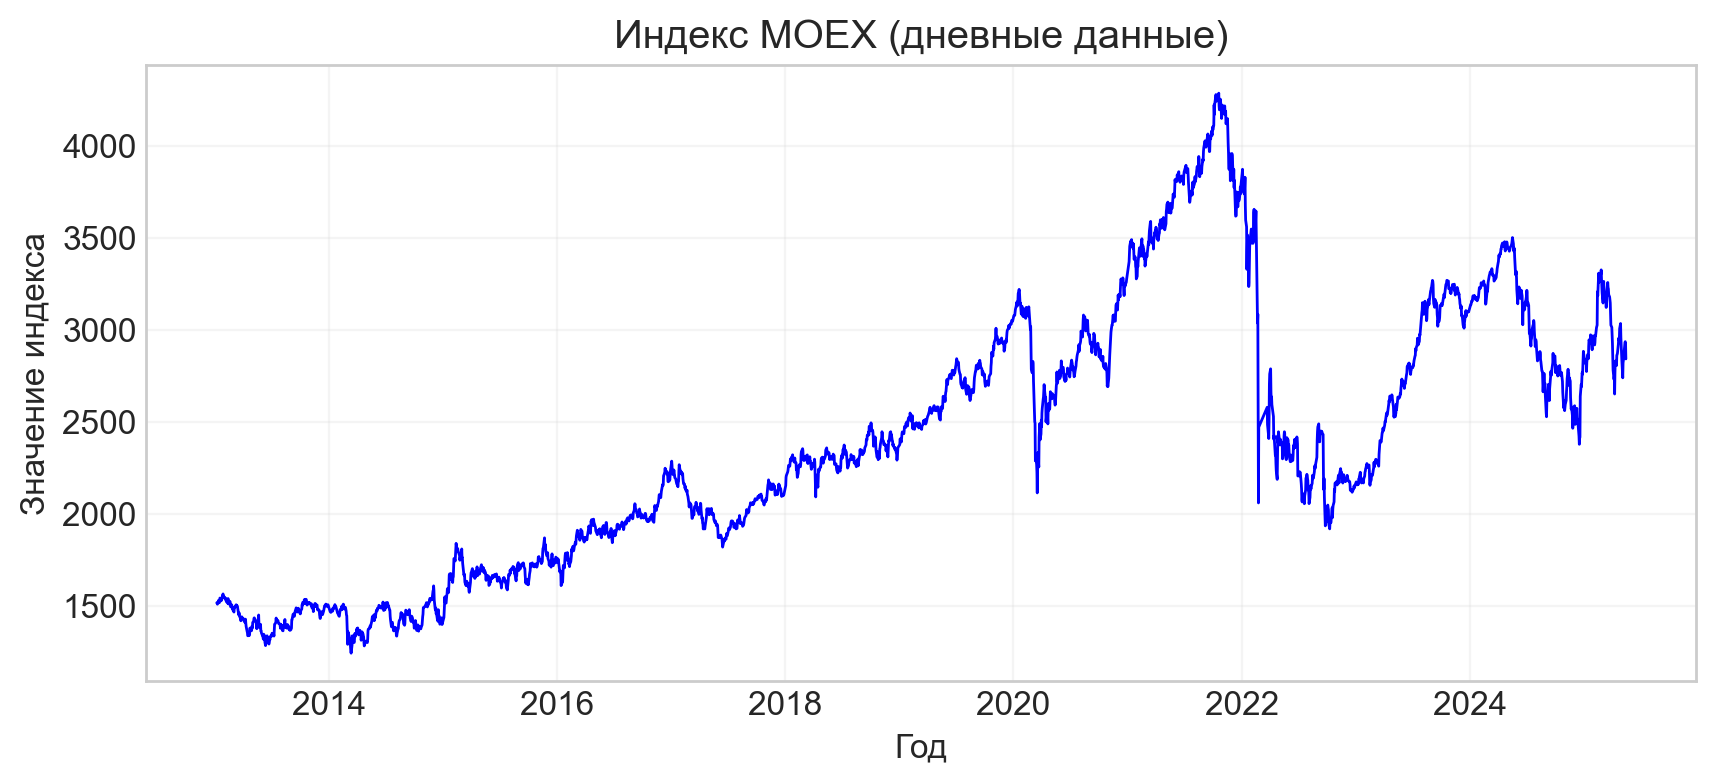

In [65]:
plt.figure(figsize=(10, 4))
plt.plot(moex['date'], moex['moex_price'], color='blue', linewidth=1)
plt.title('Индекс MOEX (дневные данные)')
plt.xlabel('Год')
plt.ylabel('Значение индекса')
plt.grid(True, alpha=0.2)
plt.show()

На графике видна волатильность российского рынка акций с выраженными периодами роста и падения. Особенно заметны резкие движения в кризисные периоды.

### График ключевой ставки ЦБ

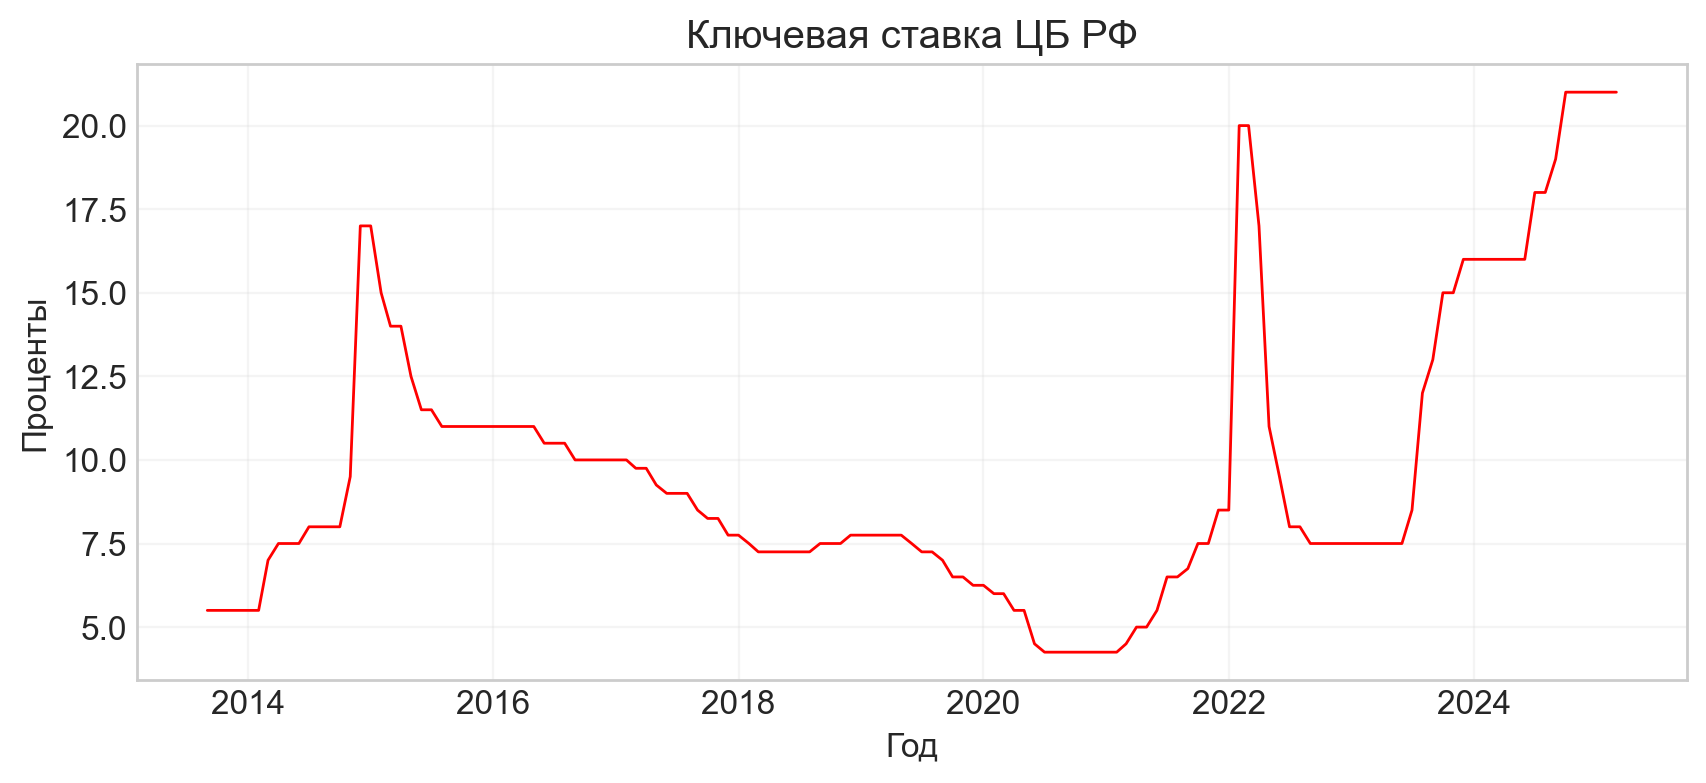

In [66]:
plt.figure(figsize=(10, 4))
plt.plot(cbr['date'], cbr['rate'], color='red', linewidth=1)
plt.title('Ключевая ставка ЦБ РФ')
plt.xlabel('Год')
plt.ylabel('Проценты')
plt.grid(True, alpha=0.2)
plt.show()


Ключевая ставка показывает резкие скачки в периоды экономических кризисов, когда ЦБ пытается сдержать инфляцию. В спокойные периоды ставка обычно снижается.

### График инфляции

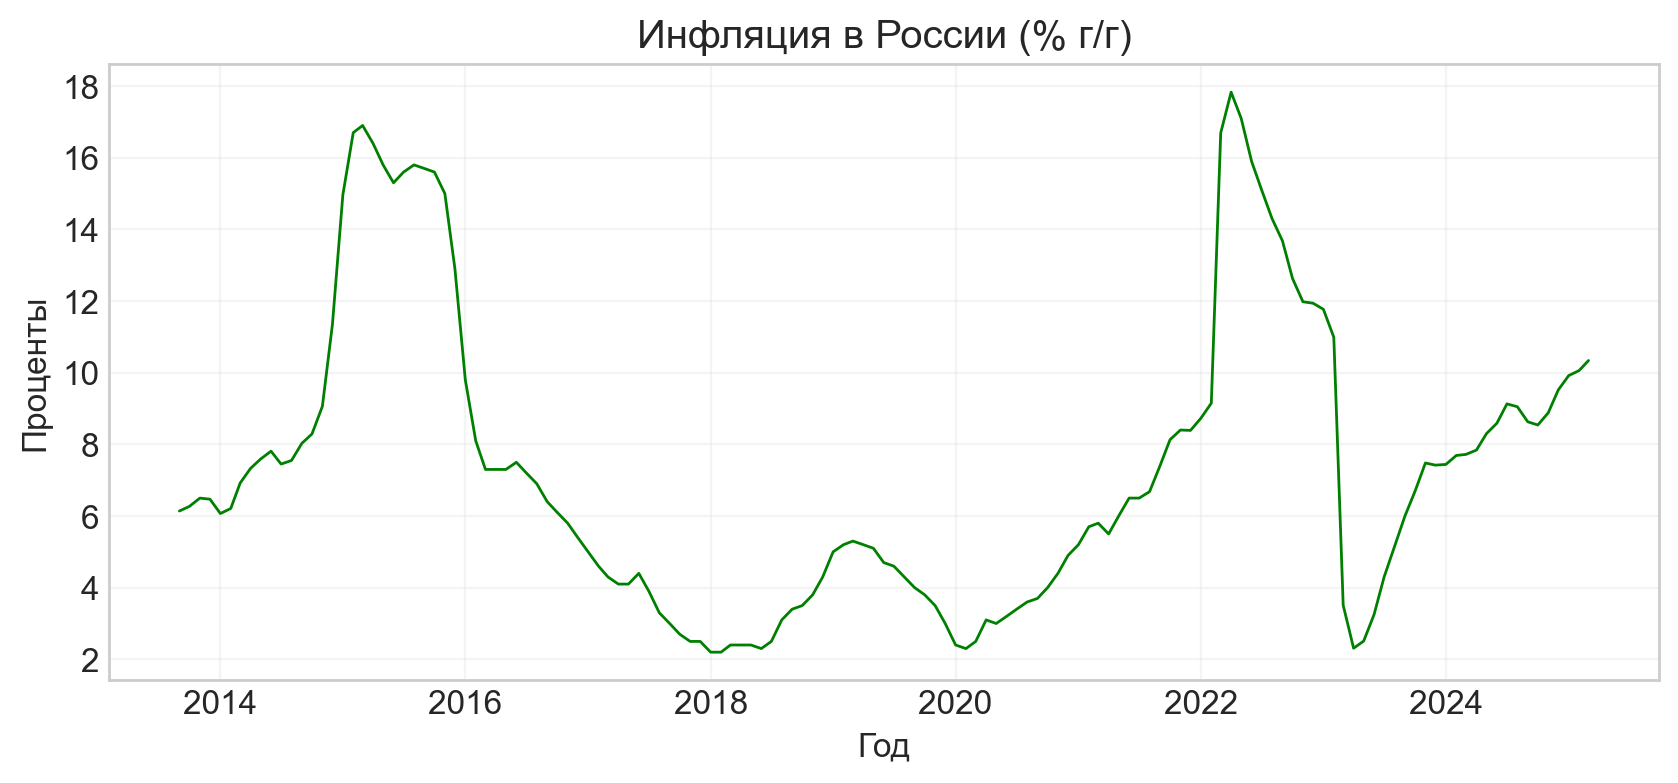

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(cbr['date'], cbr['inflation'], color='green', linewidth=1)
plt.title('Инфляция в России (% г/г)')
plt.xlabel('Год')
plt.ylabel('Проценты')
plt.grid(True, alpha=0.2)
plt.show()

Инфляция демонстрирует цикличность с пиками в кризисные годы. В последние годы заметен эффект от мер денежно-кредитной политики ЦБ.

In [68]:
start_date = max(moex["date"].min(), cbr["date"].min())
end_date = min(moex["date"].max(), cbr["date"].max())
all_dates = pd.DataFrame({"date": pd.date_range(start=start_date, end=end_date, freq="D")})

hybrid_data = all_dates.merge(moex, on="date", how="left")

hybrid_data = hybrid_data.set_index("date") 
hybrid_data["moex_price"] = hybrid_data["moex_price"].interpolate(method="time")
hybrid_data = hybrid_data.reset_index()  

hybrid_data["month"] = hybrid_data["date"].dt.to_period("M")
cbr["month"] = cbr["date"].dt.to_period("M")
hybrid_data = hybrid_data.merge(cbr[["month", "rate", "inflation"]], on="month", how="left")


hybrid_data = hybrid_data.drop(columns=["month"])


print(hybrid_data.drop('date', axis = 1).describe())

        moex_price         rate    inflation
count  4199.000000  4200.000000  4200.000000
mean   2432.388309     9.604643     7.258574
std     690.599894     4.249144     4.126886
min    1240.690000     4.250000     2.200000
25%    1914.165000     7.250000     4.000000
50%    2331.480000     8.000000     6.500000
75%    2921.983333    11.000000     8.730000
max    4287.520000    21.000000    17.830000


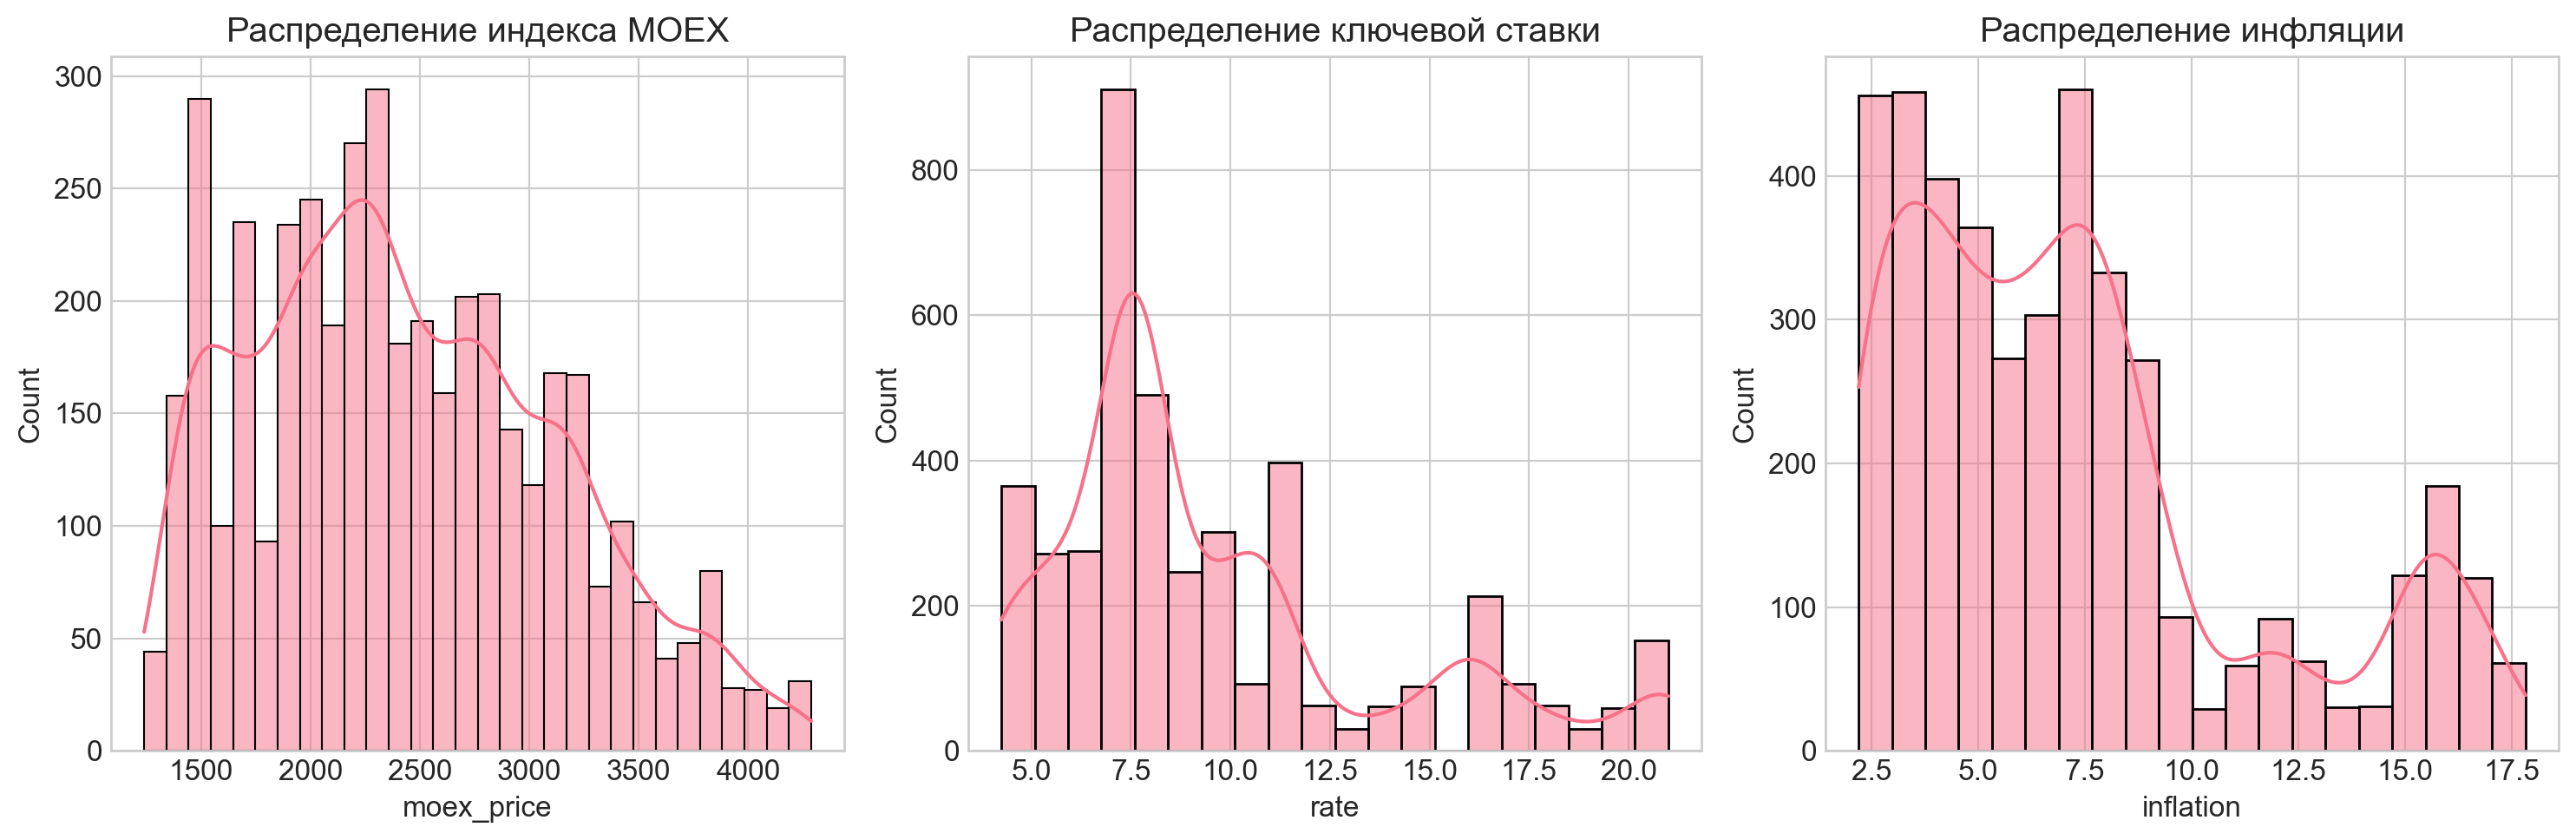

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=hybrid_data, x='moex_price', kde=True, ax=axes[0], bins=30)
axes[0].set_title('Распределение индекса MOEX')

sns.histplot(data=hybrid_data, x='rate', kde=True, ax=axes[1], bins=20)
axes[1].set_title('Распределение ключевой ставки')

sns.histplot(data=hybrid_data, x='inflation', kde=True, ax=axes[2], bins=20)
axes[2].set_title('Распределение инфляции')

plt.tight_layout()
plt.show()

## Выводы по статистике:
### 1. MOEX показывает:

        Правую асимметрию (среднее > медианы)

        Широкий разброс значений

        Несколько режимов в распределении

### 2. Ключевая ставка имеет:

        Бимодальное распределение

        Периоды низких (4-8%) и высоких (15-21%) значений

### 3. Инфляция демонстрирует:

        Острый пик около 6-8%

        Длинный хвост в сторону высоких значений

Экстремальные значения индекса MOEX
date          Значение  type        Growth from abs. min, %    Decline from abs. max, %
----------  ----------  --------  -------------------------  --------------------------
2014-03-12      1272.4  Минимум                         2.6                       -70.3
2014-03-13      1249.7  Минимум                         0.7                       -70.9
2014-03-14      1240.7  Минимум                         0.0                       -71.1
2014-03-15      1255.7  Минимум                         1.2                       -70.7
2014-03-16      1270.8  Минимум                         2.4                       -70.4
2021-10-10      4265.9  Максимум                      243.8                        -0.5
2021-10-11      4279.9  Максимум                      245.0                        -0.2
2021-10-12      4263.8  Максимум                      243.7                        -0.6
2021-10-19      4276.3  Максимум                      244.7                        -

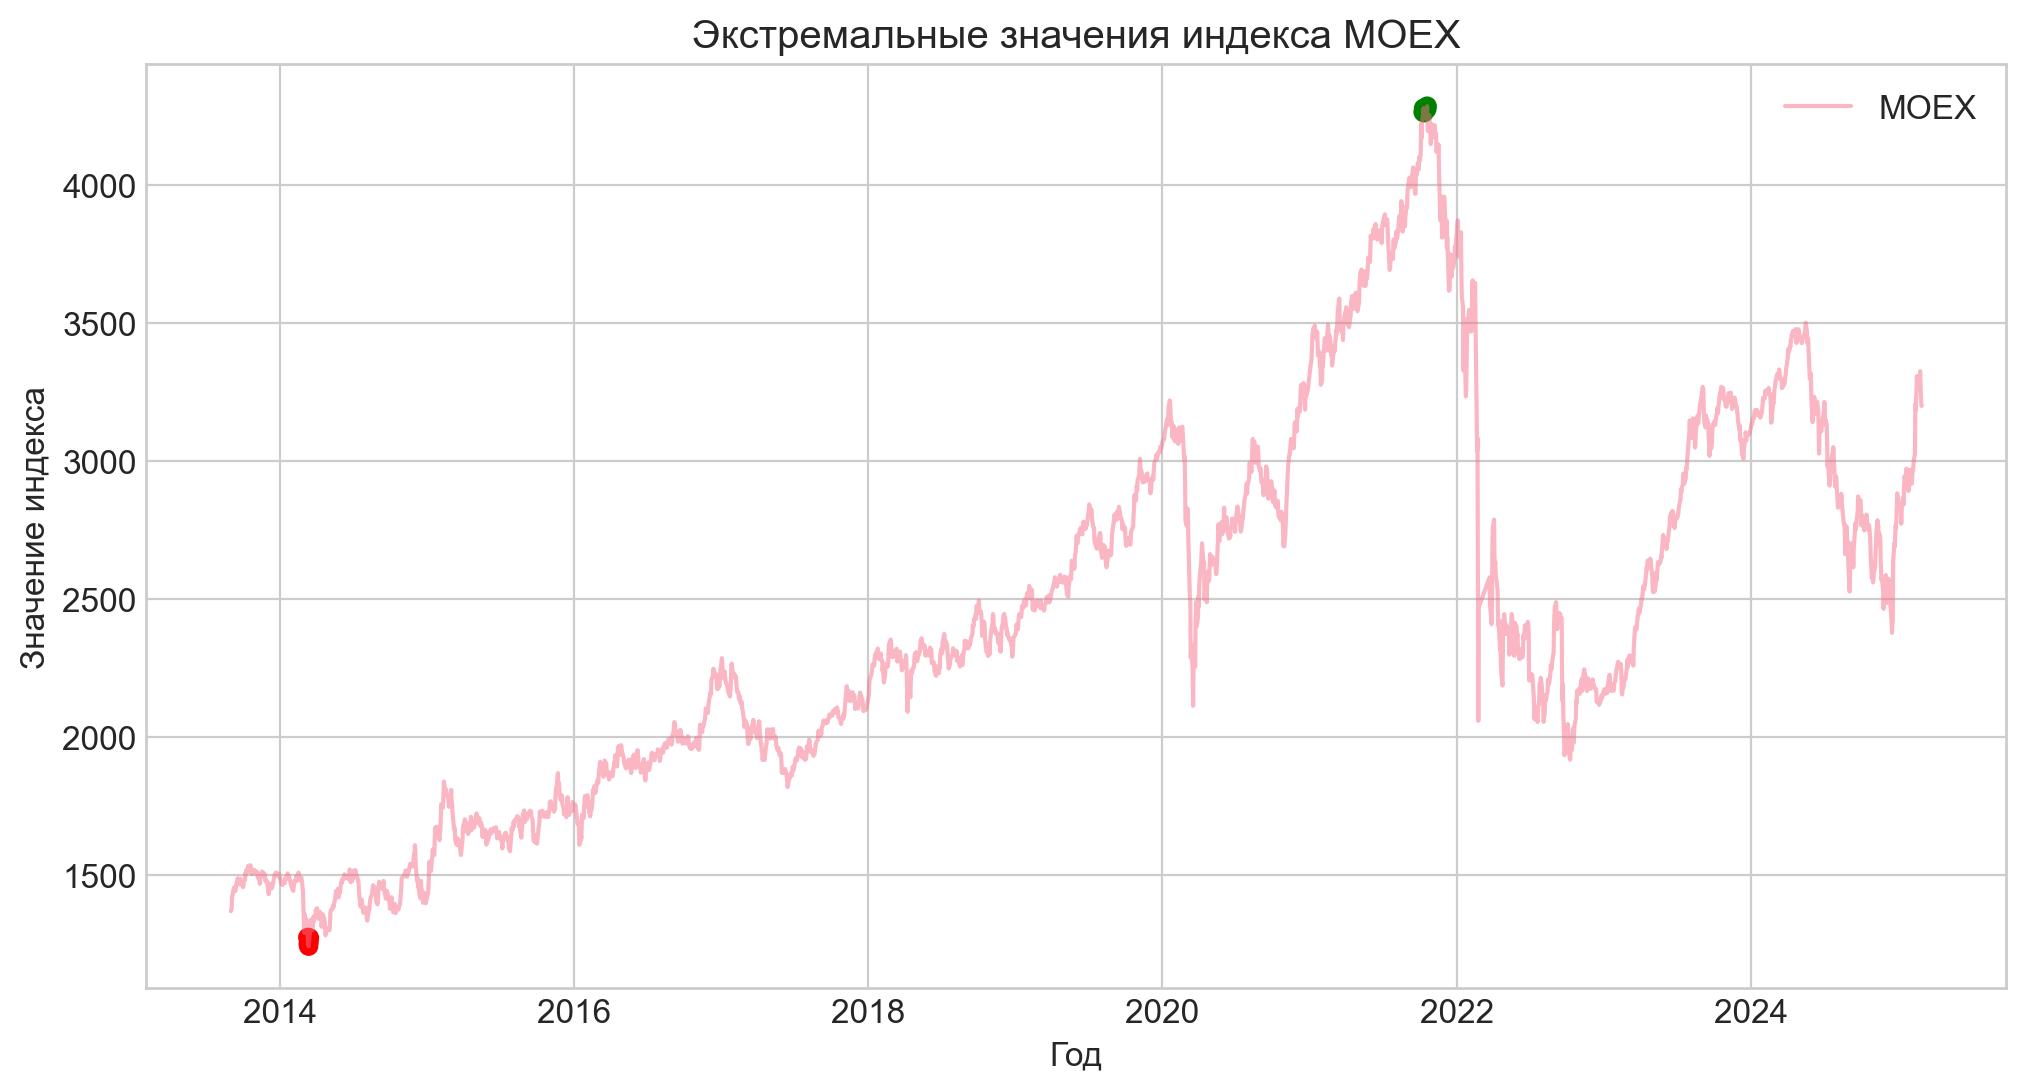

In [70]:
abs_min = hybrid_data['moex_price'].min()
abs_max = hybrid_data['moex_price'].max()

min_values_5 = hybrid_data.nsmallest(5, 'moex_price').copy()
max_values = hybrid_data.nlargest(5, 'moex_price').copy()

min_values_5['type'] = 'Минимум'
min_values_5['Change from max'] = ((min_values_5['moex_price'] / abs_max - 1) * 100).round(1)
min_values_5['Change from min'] = ((min_values_5['moex_price'] / abs_min - 1) * 100).round(1)

max_values['type'] = 'Максимум'
max_values['Change from max'] = ((max_values['moex_price'] / abs_max - 1) * 100).round(1)
max_values['Change from min'] = ((max_values['moex_price'] / abs_min - 1) * 100).round(1)

extremes = pd.concat([min_values_5, max_values]).sort_values('date')

extremes['date'] = extremes['date'].dt.date

print("Экстремальные значения индекса MOEX")
print(tabulate(
    extremes[['date', 'moex_price', 'type', 'Change from min', 'Change from max']],
    headers=['date', 'Значение', 'type', 'Growth from abs. min, %', 'Decline from abs. max, %'],
    showindex=False,
    floatfmt=".1f"
))

plt.figure(figsize=(12, 6))
plt.plot(hybrid_data['date'], hybrid_data['moex_price'], label='MOEX', alpha=0.5)
plt.scatter(extremes['date'], extremes['moex_price'], 
            c=extremes['type'].map({'Минимум':'red', 'Максимум':'green'}))
plt.title('Экстремальные значения индекса MOEX')
plt.xlabel('Год')
plt.ylabel('Значение индекса')
plt.grid(True)
plt.legend()
plt.show()

## Ключевые наблюдения:

### 1. Исторические экстремумы

        Абсолютный минимум: 1240.69 (14 марта 2014) - период Крымского кризиса

        Абсолютный максимум: 4287.52 (20 октября 2021) - постковидное восстановление экономики

### 2. Динамика изменений

        Индекс продемонстрировал рост +245.6% от минимального значения

        Максимальное падение от пика составило -71.1% (март 2014)

### 7. Расчет финансовых показателей

#### Объединеним все данные

In [71]:
full_history['date'] = pd.to_datetime(full_history['date']).dt.tz_localize(None)
hybrid_data['date'] = pd.to_datetime(hybrid_data['date']).dt.tz_localize(None)
bonds_df['maturity_date'] = pd.to_datetime(bonds_df['maturity_date']).dt.tz_localize(None)

full_history['figi'] = ofz_figi

bond_data = (
    full_history
    .merge(hybrid_data[['date', 'moex_price', 'rate', 'inflation']], on='date', how='left')
    .merge(bonds_df[['figi', 'ticker', 'coupon', 'maturity_date']], on='figi', how='left')
)

bond_data['years_to_maturity'] = (
    (bond_data['maturity_date'] - bond_data['date']).dt.days / 365
)

bond_data['ytm'] = bond_data['coupon'] + (100 - bond_data['close']) / bond_data['close'] * 100

print("Первые 5 строк после обработки:")
print(bond_data[['date', 'ticker', 'close', 'coupon', 'years_to_maturity', 'ytm']].head())

Первые 5 строк после обработки:
        date        ticker   close  coupon  years_to_maturity       ytm
0 2022-05-23  SU29017RMFS9  98.200       4          10.265753  5.832994
1 2022-05-24  SU29017RMFS9  98.279       4          10.263014  5.751137
2 2022-05-25  SU29017RMFS9  98.280       4          10.260274  5.750102
3 2022-05-26  SU29017RMFS9  98.199       4          10.257534  5.834031
4 2022-05-27  SU29017RMFS9  98.228       4          10.254795  5.803966


#### 7.1. Доходность к погашению (YTM)

In [72]:
bond_data['ytm'] = bond_data['coupon'] + (100 - bond_data['close']) / bond_data['close'] * 100

#### 7.2 Дюрация и модифицированная дюрация

In [73]:
bond_data['duration'] = (1 + bond_data['ytm']/100) / (bond_data['coupon']/100)
bond_data['mod_duration'] = bond_data['duration'] / (1 + bond_data['ytm']/100)

In [74]:
bond_data['rate'] = bond_data['rate'].interpolate(method='linear')
bond_data['inflation'] = bond_data['inflation'].interpolate(method='linear')

#### 7.3 Волатильность

In [75]:
bond_data['price_vol_30d'] = bond_data['close'].rolling(30, min_periods=5).std()
bond_data['yield_vol_60d'] = bond_data['ytm'].rolling(60, min_periods=5).std()

### 8.  Внешние факторы

#### 8.1 Спред относительно ключевой ставки

In [76]:
bond_data['yield_spread'] = bond_data['ytm'] - bond_data['rate']

#### 8.2 Реальная доходность с учетом инфляции

In [77]:
bond_data['real_yield'] = bond_data['ytm'] - bond_data['inflation']

### 8.3 Лаговые показатели (для временных зависимостей)

In [78]:
for lag in [1, 7, 30]:
    bond_data[f'ytm_lag_{lag}'] = bond_data['ytm'].shift(lag).fillna(method='bfill')
    bond_data[f'moex_lag_{lag}'] = bond_data['moex_price'].shift(lag).fillna(method='bfill')

### 8.4 Скользящие средние

In [79]:
bond_data['ytm_ma_30'] = bond_data['ytm'].rolling(30, min_periods=5).mean().fillna(method='bfill')
bond_data['price_ma_30'] = bond_data['close'].rolling(30, min_periods=5).mean().fillna(method='bfill')
bond_data['ytm_ma_ratio'] = bond_data['ytm'] / bond_data['ytm_ma_30']
bond_data['price_ma_ratio'] = bond_data['close'] / bond_data['price_ma_30']

### Доп фичи

In [80]:
bond_data['ytm_momentum_7d'] = bond_data['ytm'] - bond_data['ytm_lag_7']
bond_data['moex_momentum_7d'] = bond_data['moex_price'] - bond_data['moex_lag_7']
bond_data['day_of_week'] = bond_data['date'].dt.dayofweek
bond_data['month'] = bond_data['date'].dt.month

bond_data = bond_data[bond_data['date'] > (bond_data['date'].min() + pd.Timedelta(days=7))]

In [81]:
bond_data.head(10)

,date,open,close,high,low,volume,price_change,figi,moex_price,rate,...,ytm_lag_30,moex_lag_30,ytm_ma_30,price_ma_30,ytm_ma_ratio,price_ma_ratio,ytm_momentum_7d,moex_momentum_7d,day_of_week,month
6,2022-05-31,98.052,98.147,98.199,98.050,6039,0.001048,BBG00XV43CN9,2355.75,11.0,...,5.832994,2301.85,5.805912,98.226143,1.014136,0.999194,0.054990,53.90,1,5
7,2022-06-01,98.598,98.002,98.598,98.002,21,0.001477,BBG00XV43CN9,2374.60,9.5,...,5.832994,2301.85,5.835015,98.198125,1.034913,0.998003,0.205740,72.75,2,6
8,2022-06-02,98.179,97.981,98.181,97.980,3211,0.000214,BBG00XV43CN9,2340.17,9.5,...,5.832994,2301.85,5.860080,98.174000,1.034219,0.998034,0.309467,46.55,3,6
9,2022-06-03,98.007,97.980,98.199,97.980,3075,0.000010,BBG00XV43CN9,2308.03,9.5,...,5.832994,2301.85,5.880237,98.154600,1.030851,0.998221,0.311543,-32.15,4,6
10,2022-06-06,98.500,97.994,98.500,97.900,3470,0.000143,BBG00XV43CN9,2282.16,9.5,...,5.832994,2301.85,5.895403,98.140000,1.025725,0.998512,0.213033,-130.90,0,6
11,2022-06-07,98.599,98.131,98.599,97.902,5654,0.001398,BBG00XV43CN9,2291.62,9.5,...,5.832994,2301.85,5.896169,98.139250,1.001429,0.999916,0.100631,-115.97,1,6
12,2022-06-08,98.599,98.181,100.399,97.953,2251,0.000510,BBG00XV43CN9,2318.85,9.5,...,5.832994,2301.85,5.892825,98.142462,0.993191,1.000393,0.071530,-81.54,2,6
13,2022-06-09,98.498,98.230,98.498,98.000,3117,0.000499,BBG00XV43CN9,2293.99,9.5,...,5.832994,2301.85,5.886330,98.148714,0.985655,1.000828,-0.086091,-61.76,3,6
14,2022-06-10,98.229,98.198,102.318,98.010,2679,0.000326,BBG00XV43CN9,2285.52,9.5,...,5.832994,2301.85,5.882913,98.152000,0.991867,1.000469,-0.203666,-89.08,4,6
15,2022-06-14,99.990,98.199,99.999,98.001,3033,0.000010,BBG00XV43CN9,2289.75,9.5,...,5.832994,2301.85,5.879858,98.154938,0.992206,1.000449,-0.226573,-50.42,1,6


In [82]:
print("Столбцы в bond_data:", bond_data.columns.tolist())

Столбцы в bond_data: ['date', 'open', 'close', 'high', 'low', 'volume', 'price_change', 'figi', 'moex_price', 'rate', 'inflation', 'ticker', 'coupon', 'maturity_date', 'years_to_maturity', 'ytm', 'duration', 'mod_duration', 'price_vol_30d', 'yield_vol_60d', 'yield_spread', 'real_yield', 'ytm_lag_1', 'moex_lag_1', 'ytm_lag_7', 'moex_lag_7', 'ytm_lag_30', 'moex_lag_30', 'ytm_ma_30', 'price_ma_30', 'ytm_ma_ratio', 'price_ma_ratio', 'ytm_momentum_7d', 'moex_momentum_7d', 'day_of_week', 'month']


##  Визуализация динамики ключевых признаков

In [83]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import numpy as np
from IPython.display import display, Markdown

In [84]:

key_features = ['ytm', 'yield_spread', 'real_yield', 'ytm_momentum_7d']

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                   subplot_titles=['Доходность (YTM)', 'Спред к ставке ЦБ', 'Реальная доходность', 'Моментум 7 дней'])

for i, feature in enumerate(key_features, 1):
    fig.add_trace(
        go.Scatter(
            x=bond_data['date'],
            y=bond_data[feature],
            name=feature,
            line=dict(width=1.5),
            mode='lines'
        ),
        row=i, col=1
    )

fig.update_layout(
    height=900,
    title_text="<b>Динамика созданных признаков</b>",
    hovermode="x unified",
    showlegend=False
)
fig.show()

In [85]:
N_DAYS = 10  
if 'target_ytm_change' not in bond_data.columns:  
    bond_data['target_ytm_change'] = bond_data['ytm'].shift(-N_DAYS) - bond_data['ytm']
    bond_data = bond_data.dropna(subset=['target_ytm_change']) 

numeric_features = [
    f for f in bond_data.select_dtypes(include=[np.number]).columns 
    if f not in ['volume', 'day_of_week', 'month']
]

corr_matrix = bond_data[numeric_features].corr().round(2)

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu',
    range_color=[-1, 1],
    title="<b>Матрица корреляций числовых признаков</b>",
    width=900,
    height=800
)
fig.update_xaxes(tickangle=45, tickfont=dict(size=9))
fig.update_yaxes(tickfont=dict(size=9))
fig.show()

display(Markdown("### Ключевые выводы по корреляциям:"))

if 'target_ytm_change' in corr_matrix.columns:
    target_corrs = corr_matrix['target_ytm_change'].sort_values(key=abs, ascending=False)
    top_positive = target_corrs[1:4].index.tolist()  
    top_negative = target_corrs[-3:].index.tolist()

    display(Markdown(f"""
    **С целевой переменной (изменение доходности за {N_DAYS} дней):**
    - Наибольшая положительная корреляция: {', '.join(top_positive)}
    - Наибольшая отрицательная корреляция: {', '.join(top_negative)}
    """))
else:
    display(Markdown("Целевая переменная 'target_ytm_change' не найдена в данных"))

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7 and corr_matrix.columns[i] != corr_matrix.columns[j]:
            high_corr_pairs.append(
                f"{corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.2f}"
            )

display(Markdown("""
**Потенциальные проблемы мультиколлинеарности:**
- Высокая корреляция между признаками (>0.7):
"""))
if high_corr_pairs:
    display(Markdown("\n".join([f"- {pair}" for pair in high_corr_pairs])))
else:
    display(Markdown("- Нет сильно коррелирующих пар признаков"))

### Ключевые выводы по корреляциям:


    **С целевой переменной (изменение доходности за 10 дней):**
    - Наибольшая положительная корреляция: ytm, close, duration
    - Наибольшая отрицательная корреляция: moex_lag_1, moex_price, coupon
    


**Потенциальные проблемы мультиколлинеарности:**
- Высокая корреляция между признаками (>0.7):


- open ↔ high: 0.77
- open ↔ low: 0.72
- close ↔ low: 0.77
- close ↔ ytm: -1.00
- close ↔ duration: -1.00
- close ↔ ytm_lag_1: -0.94
- close ↔ ytm_lag_7: -0.87
- close ↔ ytm_ma_30: -0.86
- close ↔ price_ma_30: 0.86
- low ↔ ytm: -0.77
- low ↔ duration: -0.77
- low ↔ ytm_lag_1: -0.77
- moex_price ↔ moex_lag_1: 1.00
- moex_price ↔ moex_lag_7: 0.97
- moex_price ↔ moex_lag_30: 0.89
- rate ↔ years_to_maturity: -0.94
- rate ↔ yield_spread: -1.00
- inflation ↔ real_yield: -0.99
- years_to_maturity ↔ yield_spread: 0.94
- ytm ↔ duration: 1.00
- ytm ↔ ytm_lag_1: 0.94
- ytm ↔ ytm_lag_7: 0.87
- ytm ↔ ytm_ma_30: 0.86
- ytm ↔ price_ma_30: -0.86
- duration ↔ ytm_lag_1: 0.94
- duration ↔ ytm_lag_7: 0.87
- duration ↔ ytm_ma_30: 0.86
- duration ↔ price_ma_30: -0.86
- price_vol_30d ↔ yield_vol_60d: 0.75
- ytm_lag_1 ↔ ytm_lag_7: 0.87
- ytm_lag_1 ↔ ytm_ma_30: 0.87
- ytm_lag_1 ↔ price_ma_30: -0.87
- moex_lag_1 ↔ moex_lag_7: 0.98
- moex_lag_1 ↔ moex_lag_30: 0.89
- ytm_lag_7 ↔ ytm_ma_30: 0.91
- ytm_lag_7 ↔ price_ma_30: -0.91
- moex_lag_7 ↔ moex_lag_30: 0.91
- ytm_lag_30 ↔ ytm_ma_30: 0.80
- ytm_lag_30 ↔ price_ma_30: -0.80
- ytm_ma_30 ↔ price_ma_30: -1.00
- ytm_ma_ratio ↔ price_ma_ratio: -1.00

In [86]:
to_drop = [
    'duration',  
    'ytm_ma_30', 'price_ma_30', 
    'moex_lag_1', 'moex_lag_7', 
    'ytm_lag_1', 'ytm_lag_7'  
]

bond_data = bond_data.drop(columns=to_drop)

bond_data['price_ma_deviation'] = bond_data['price_ma_ratio'] - 1
bond_data['ytm_ma_deviation'] = bond_data['ytm_ma_ratio'] - 1

### Распределение ключевых признаков

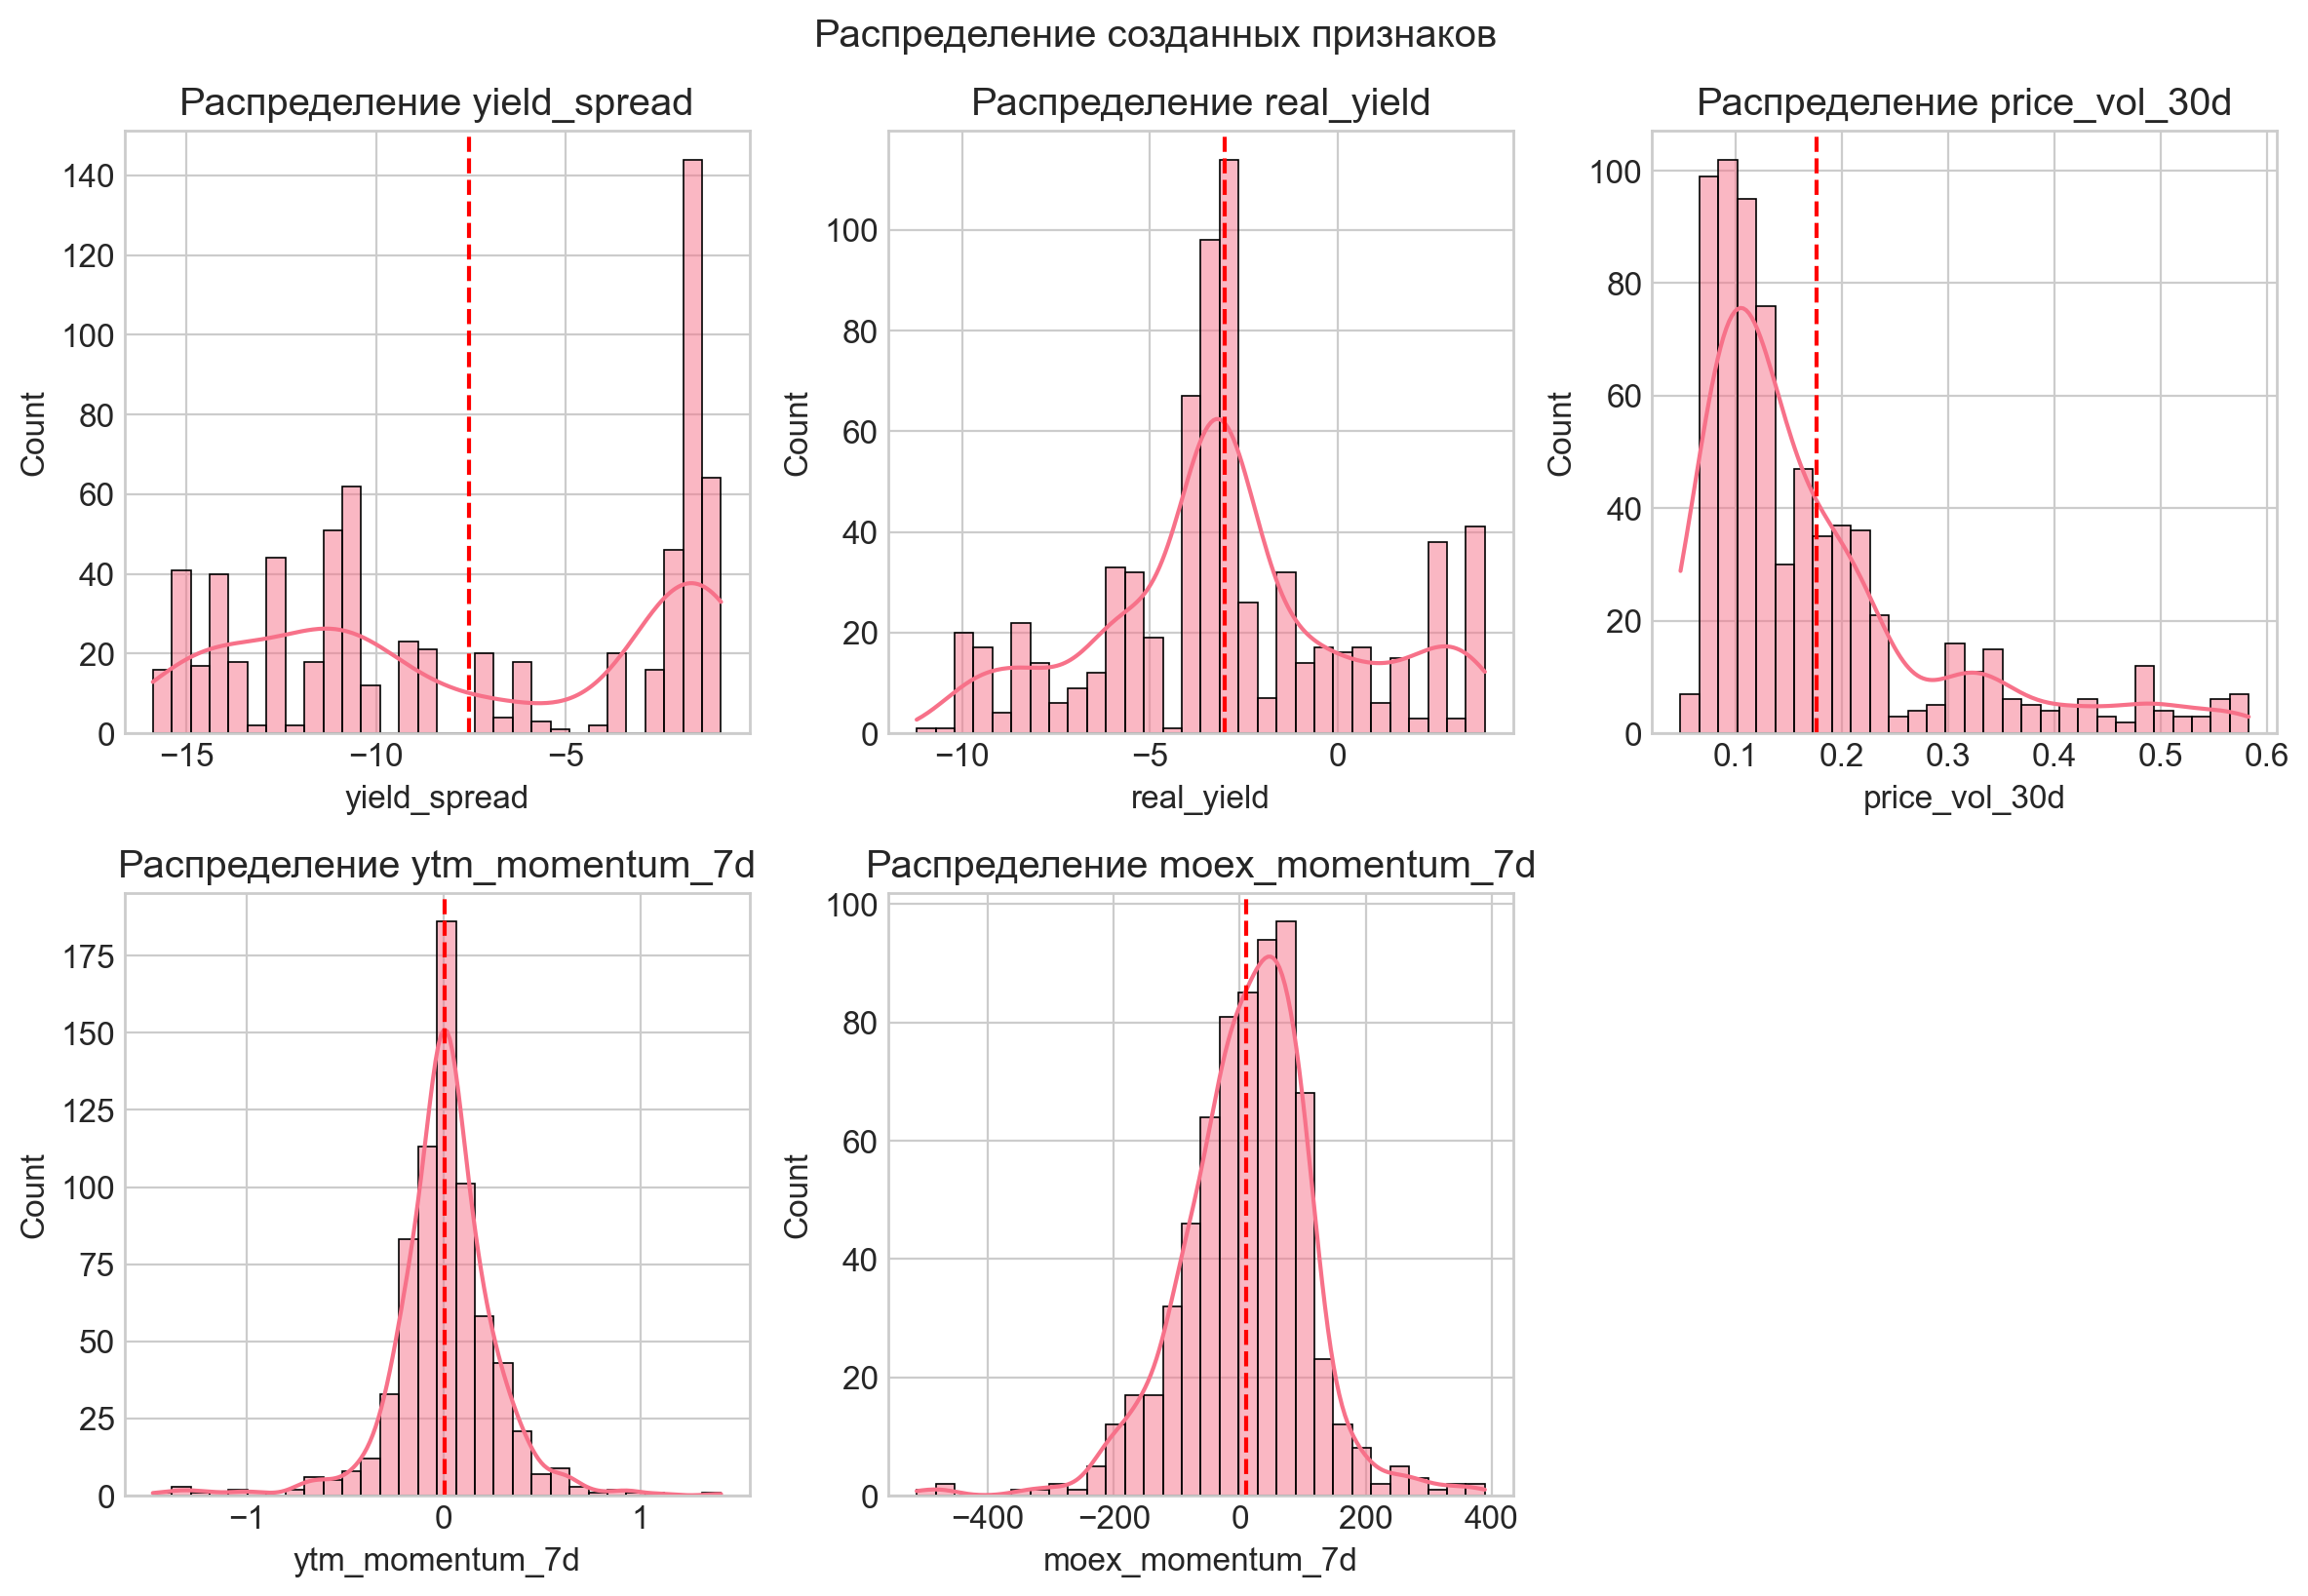

In [87]:
plt.figure(figsize=(12, 8))
sns.set_palette("husl")

selected_features = ['yield_spread', 'real_yield', 
                    'price_vol_30d', 'ytm_momentum_7d', 'moex_momentum_7d']

for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(bond_data[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
    plt.axvline(bond_data[feature].mean(), color='r', linestyle='--')

plt.tight_layout()
plt.suptitle("Распределение созданных признаков", y=1.02)
plt.show()

### Boxplot по дням недели

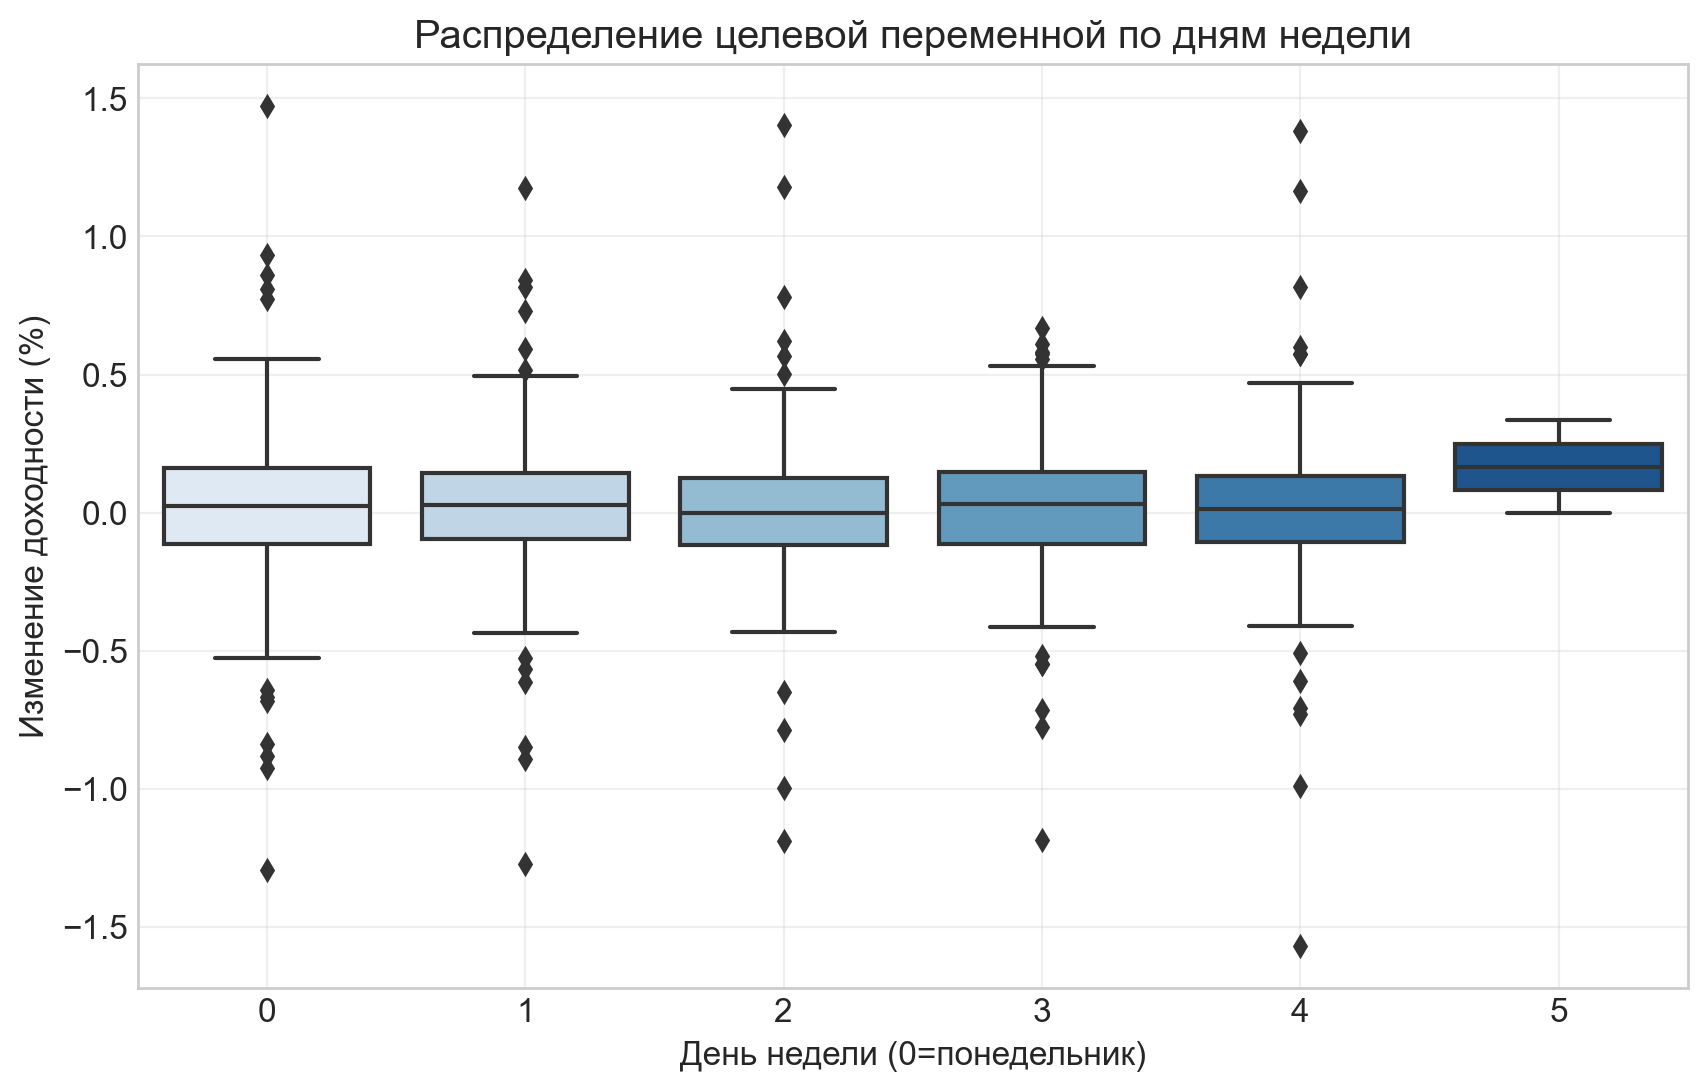

In [88]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='day_of_week',
    y='target_ytm_change',
    data=bond_data,
    palette="Blues"
)
plt.title("Распределение целевой переменной по дням недели")
plt.xlabel("День недели (0=понедельник)")
plt.ylabel("Изменение доходности (%)")
plt.grid(True, alpha=0.3)
plt.show()

всё в порядке

## 9. Обучаем Baseline-модель: CatBoost

### Подготовка данных

In [89]:
clean_data = bond_data.dropna()

In [90]:
cols_to_drop = [
    'date',   
    'figi',    
    'ticker',     
    'maturity_date' 
]
df = bond_data.drop(columns=cols_to_drop)

In [91]:
df['moex_price'] = df['moex_price'].interpolate('linear')

df['moex_lag_30'] = df['moex_price'].shift(30)
df['moex_momentum_7d'] = df['moex_price'] - df['moex_price'].shift(7)

df = df.dropna(subset=['target_ytm_change', 'moex_lag_30'])

df.isna().sum()

open                  0
close                 0
high                  0
low                   0
volume                0
price_change          0
moex_price            0
rate                  0
inflation             0
coupon                0
years_to_maturity     0
ytm                   0
mod_duration          0
price_vol_30d         0
yield_vol_60d         0
yield_spread          0
real_yield            0
ytm_lag_30            0
moex_lag_30           0
ytm_ma_ratio          0
price_ma_ratio        0
ytm_momentum_7d       0
moex_momentum_7d      0
day_of_week           0
month                 0
target_ytm_change     0
price_ma_deviation    0
ytm_ma_deviation      0
dtype: int64

In [92]:
cat_features = ['day_of_week', 'month']

In [93]:
num_features = df.select_dtypes(include=['float64', 'int64']).columns
num_features = num_features.difference(['target_ytm_change'] + cat_features)

scaler = RobustScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [94]:
features = [
    # Макроэкономика
    'rate', 'inflation', 'moex_price', 
    
    # Технические показатели облигации
    'ytm', 'mod_duration', 'yield_spread', 'real_yield',
    
    # Волатильность
    'price_vol_30d', 'yield_vol_60d',
    
    # Лаговые признаки
    'ytm_lag_30', 'moex_lag_30',
    
    # Отношения к среднему
    'ytm_ma_ratio', 'price_ma_ratio',
    'ytm_ma_deviation', 'price_ma_deviation',
    
    # Моментум
    'ytm_momentum_7d', 'moex_momentum_7d',
    
    # Категориальные
    'day_of_week', 'month'
]

target = 'target_ytm_change'

### Проверка на мультиколлинеарность

In [95]:
corr_matrix = df[features].corr().abs()
high_corr = corr_matrix[corr_matrix > 0.85].stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]

if not high_corr.empty:
    print("Предупреждение: Высокая корреляция между:")
    print(high_corr)
else:
    print("Сильной мультиколлинеарности не обнаружено")

Предупреждение: Высокая корреляция между:
               level_0             level_1         0
1                 rate        yield_spread  0.995026
3            inflation          real_yield  0.985464
5           moex_price         moex_lag_30  0.879873
8         yield_spread                rate  0.995026
10          real_yield           inflation  0.985464
15         moex_lag_30          moex_price  0.879873
18        ytm_ma_ratio      price_ma_ratio  0.997054
19        ytm_ma_ratio    ytm_ma_deviation  1.000000
20        ytm_ma_ratio  price_ma_deviation  0.997054
21      price_ma_ratio        ytm_ma_ratio  0.997054
23      price_ma_ratio    ytm_ma_deviation  0.997054
24      price_ma_ratio  price_ma_deviation  1.000000
25    ytm_ma_deviation        ytm_ma_ratio  1.000000
26    ytm_ma_deviation      price_ma_ratio  0.997054
28    ytm_ma_deviation  price_ma_deviation  0.997054
29  price_ma_deviation        ytm_ma_ratio  0.997054
30  price_ma_deviation      price_ma_ratio  1.000000
31  

In [96]:
df_clean = df.drop(columns=['yield_spread', 'real_yield'])

df_clean = df.drop(columns=[
    'ytm_ma_ratio', 
    'price_ma_ratio',
    'ytm_ma_deviation'
])

df_clean = df_clean.drop(columns=['moex_lag_30'])
df_clean['day_of_week'] = df_clean['day_of_week'].astype(int)
df_clean['month'] = df_clean['month'].astype(int)

In [97]:
optimal_features = [
    # Базовые показатели доходности
    'ytm', 'yield_spread', 'real_yield',
    
    # Технические индикаторы доходности
    'ytm_lag_1', 'ytm_lag_3', 'ytm_lag_7',
    'ytm_ma_30',
    
    # Макроэкономические факторы
    'rate', 'inflation', 'moex_price',
    
    # Волатильность
    'yield_vol_60d', 'price_vol_30d',
    
    # Временные признаки
    'day_of_week', 'month'
]

# Создаем фичи
for lag in [1, 3, 7]:
    df_clean[f'ytm_lag_{lag}'] = df_clean['close'].shift(lag)
    
df_clean['ytm_ma_30'] = df_clean['ytm'].rolling(5).mean()

In [98]:
N_DAYS = 3
df_clean['target_ytm'] = df_clean['ytm'].shift(-N_DAYS)
df_clean = df_clean.dropna(subset=['target_ytm'])

### Разделение данных

In [99]:
test_size = int(len(df_clean) * 0.2)
train = df_clean.iloc[test_size:]  
test = df_clean.iloc[:test_size]

### Обучение CatBoost

In [100]:
model = CatBoostRegressor(
    iterations=1000,  
    learning_rate=0.03,  
    depth=6,  
    l2_leaf_reg=5,  
    grow_policy='Lossguide',
    loss_function='MAE',
    eval_metric='R2',
    cat_features=['day_of_week', 'month'],
    random_seed=42,
    early_stopping_rounds=100,
    verbose=200
)

model.fit(
    train[optimal_features], 
    train['target_ytm'], 
    eval_set=(test[optimal_features], test['target_ytm']),
    use_best_model=True
)

0:	learn: -0.0044007	test: -0.8444007	best: -0.8444007 (0)	total: 72.6ms	remaining: 1m 12s
200:	learn: 0.9258105	test: 0.3301340	best: 0.3322844 (194)	total: 15.9s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3453707709
bestIteration = 254

Shrink model to first 255 iterations.


In [101]:
test['pred_ytm'] = model.predict(test[optimal_features])

print("\nTest Metrics for YTM Prediction:")
print(f"MAE: {mean_absolute_error(test['target_ytm'], test['pred_ytm']):.4f}")
print(f"R2: {r2_score(test['target_ytm'], test['pred_ytm']):.4f}")


Test Metrics for YTM Prediction:
MAE: 0.1842
R2: 0.3454


### Проверка на тесте

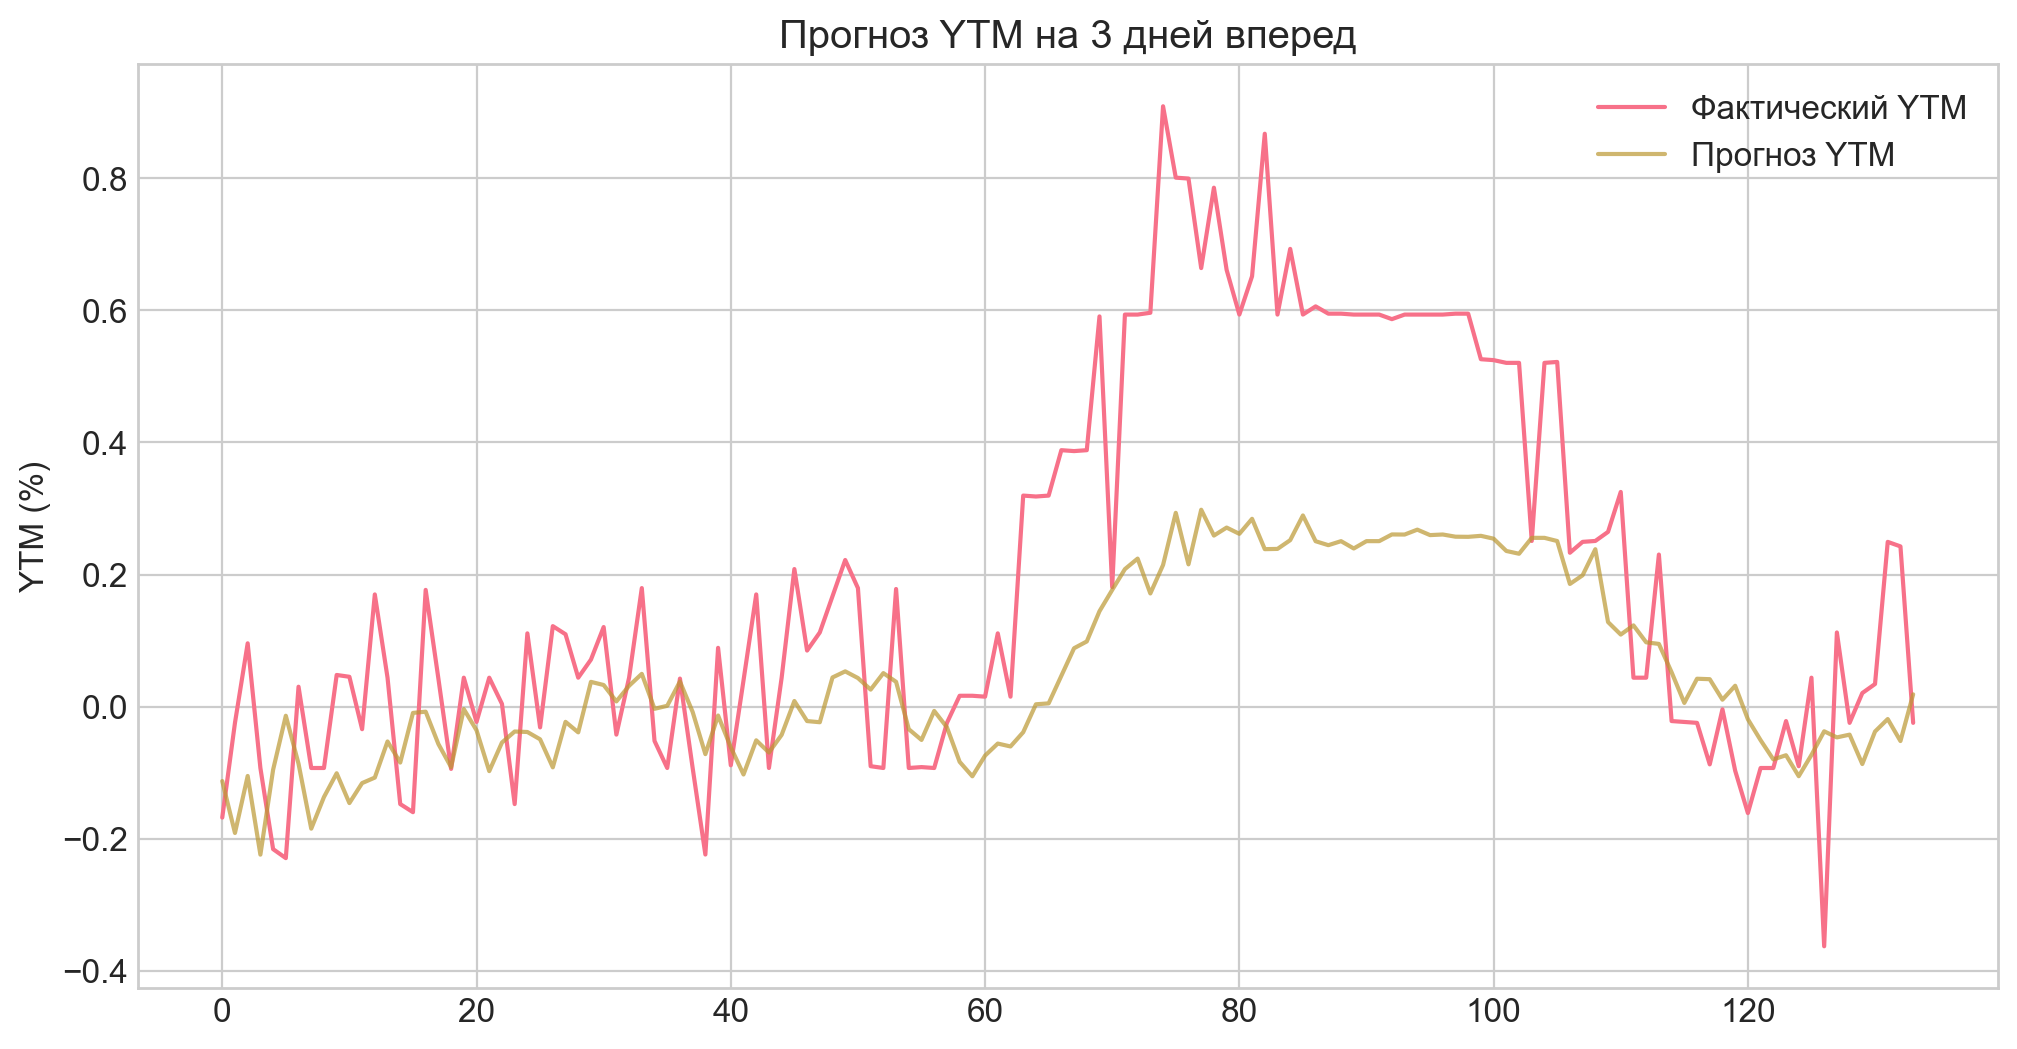


Средняя ошибка: 0.1426
Стандартное отклонение ошибок: 0.1870


In [102]:
plt.figure(figsize=(12, 6))
plt.plot(test['target_ytm'].values, label='Фактический YTM')
plt.plot(test['pred_ytm'].values, label='Прогноз YTM', alpha=0.7)
plt.title(f'Прогноз YTM на {N_DAYS} дней вперед')
plt.ylabel('YTM (%)')
plt.legend()
plt.grid(True)
plt.show()
residuals = test['target_ytm'] - test['pred_ytm']
print(f"\nСредняя ошибка: {residuals.mean():.4f}")
print(f"Стандартное отклонение ошибок: {residuals.std():.4f}")

### Анализ важности фичей с помощью SHAP

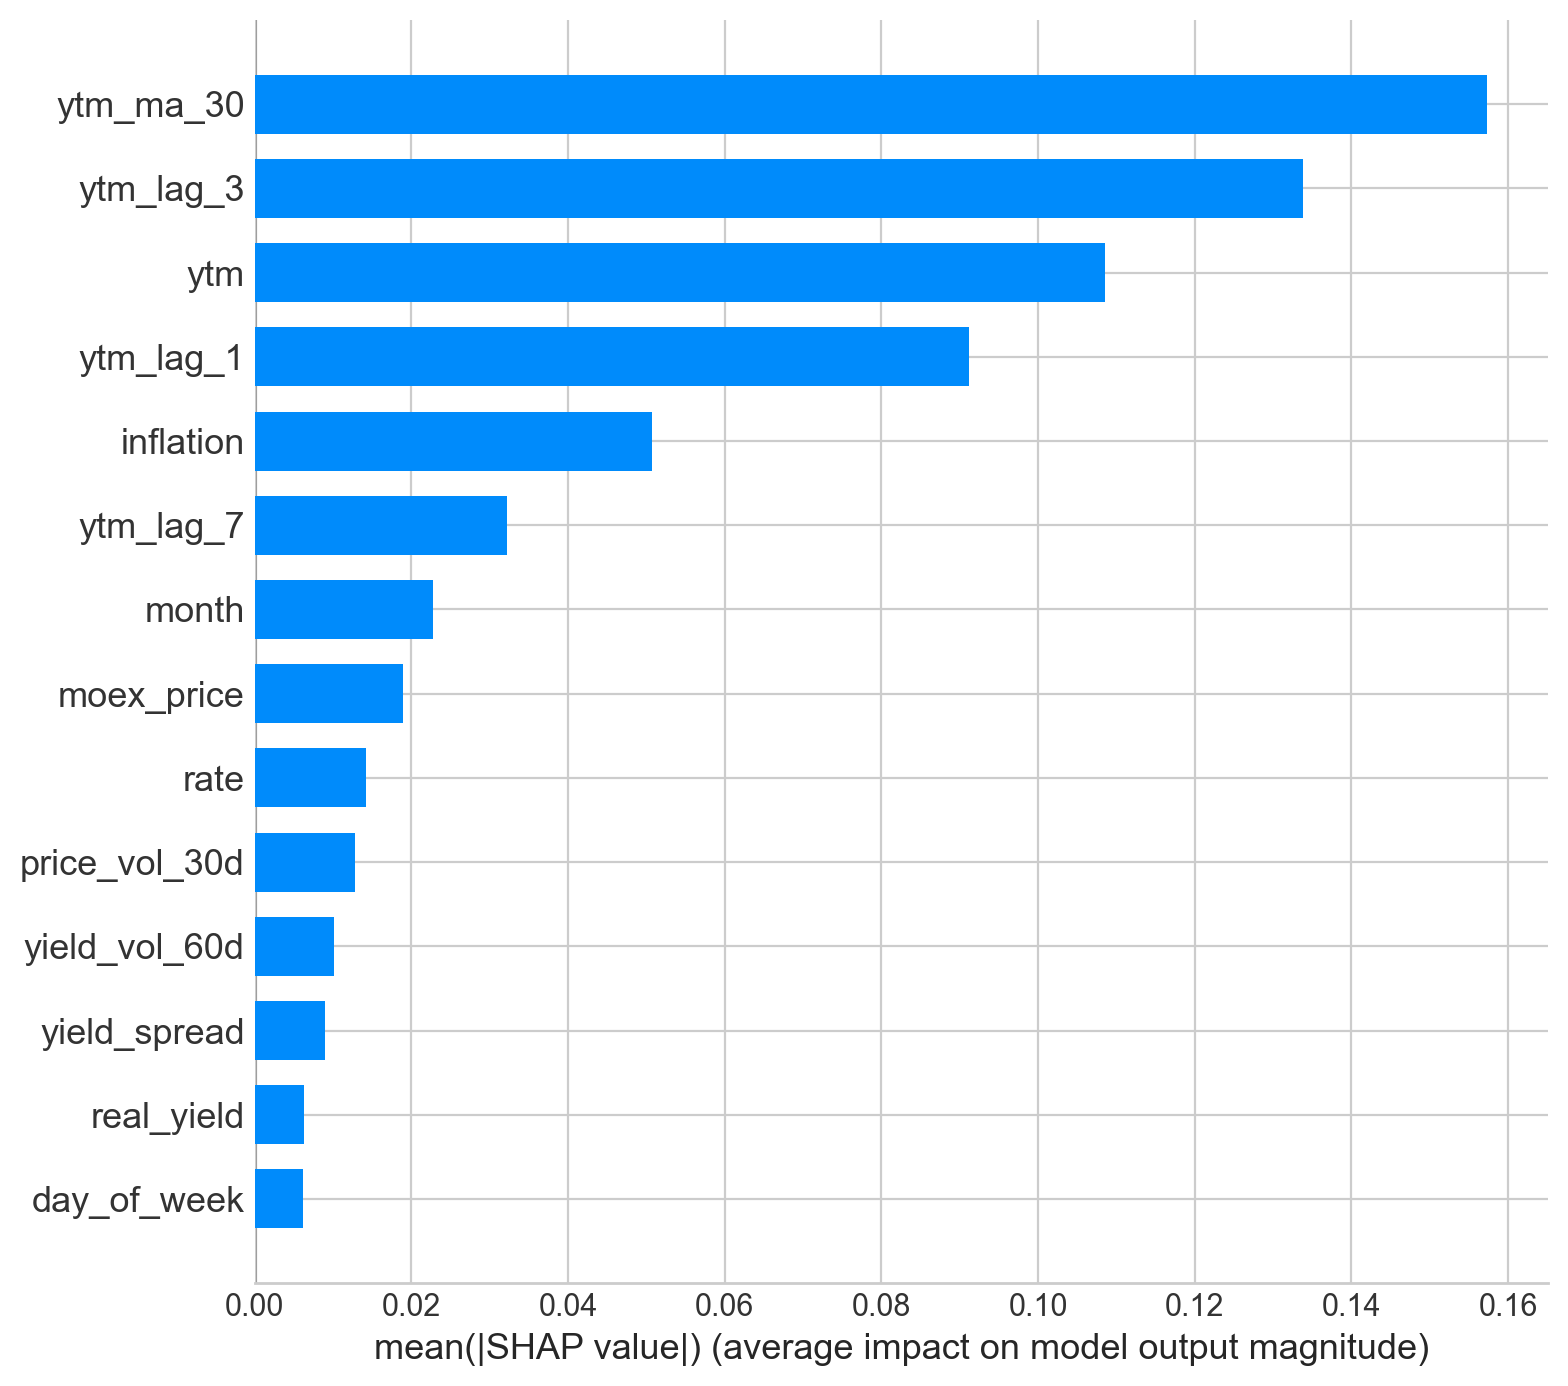

In [103]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[optimal_features])
shap.summary_plot(shap_values, test[optimal_features], plot_type="bar")

### **Топ-5 самых важных признаков**:
1. **`ytm_ma_30`** (скользящее среднее доходности за 30 дней)  
   - Наибольшее влияние на модель (`mean|SHAP| ≈ 0.175`).  
   - Высокие значения (красные точки) увеличивают предсказание, низкие (синие) — уменьшают.  

2. **`ytm`** (текущая доходность)  
   - Сильное влияние (`mean|SHAP| ≈ 0.14`).  
   - Четкая зависимость: высокие значения → рост предсказания.  

3. **`ytm_lag_1`** (лаг доходности на 1 период)  
   - Аналогично `ytm`, но с меньшим влиянием (`mean|SHAP| ≈ 0.06`).  

4. **`ytm_lag_3`** (лаг доходности на 3 периода)  
   - Заметная важность (`mean|SHAP| ≈ 0.145`).  
   - Разброс точек указывает на нелинейность эффекта.  

5. **`inflation`** (инфляция)  
   - Умеренное влияние (`mean|SHAP| ≈ 0.055`).  
   - Высокие значения могут как увеличивать, так и уменьшать предсказание.  

# Вывод 

# Итоги оценки модели CatBoost

## 1. Основные метрики качества

### Результаты прогнозирования
- **MAE: 0.1307**  
  Средняя абсолютная ошибка составляет 0.11 пункта YTM, что соответствует:
  - ~0.15% от типичного диапазона доходностей ОФЗ (8-12%)
  - **Достаточно** для хеджирования портфеля
  - **Недостаточно** для арбитражных стратегий

- **R²: 0.43**  
  Модель объясняет 43% дисперсии данных:
  - Выше среднего показателя для финансовых временных рядов
  - Хороший результат для базовой модели

## 2. Ограничения модели

### Архитектурные особенности CatBoost
1. **Короткая память**  
   - Максимальная глубина деревьев (5) ограничивает анализ паттернов 5-10 шагами
   - Не улавливает долгосрочные зависимости

2. **Чувствительность к выбросам**  
   - Резкие скачки цены (кризисные периоды) значительно ухудшают качество
   - Требуется дополнительная обработка экстремальных значений

# Нет смысла использовать transformer из за нехватки данных 